# 02 — RFM Feature Engineering & Customer Profiling

> **RFM** (Recency, Frequency, Monetary) is the industry-standard framework for customer segmentation in retail. Used by Boots, Amazon, and virtually every major retailer.

- **Recency**: How recently did the customer last purchase? (lower = better)
- **Frequency**: How often do they buy?
- **Monetary**: How much do they spend in total?

In [1]:
import os, sys
os.chdir(r'C:\Users\mohit\Downloads\retail-customer-intelligence')
sys.path.insert(0, r'C:\Users\mohit\Downloads\retail-customer-intelligence')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '.')
from src.data.loader import load_transactions
from src.data.preprocessor import clean_transactions, add_time_features, get_snapshot_date
from src.features.rfm_features import compute_rfm, score_rfm, add_behavioural_features
import warnings; warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.dpi': 120, 'axes.spines.top': False, 'axes.spines.right': False})

transactions = load_transactions()
transactions = clean_transactions(transactions)
transactions = add_time_features(transactions)
snapshot     = get_snapshot_date(transactions)
rfm          = compute_rfm(transactions, snapshot)
rfm          = score_rfm(rfm)
rfm          = add_behavioural_features(transactions, rfm)

print(f"RFM table shape: {rfm.shape}")
print(f"\nSample:")
rfm.head()


2026-02-21 11:10:17,042 | INFO | src.data.loader | Loading transactions from data/raw/transactions.csv
2026-02-21 11:10:17,238 | INFO | src.data.loader | Loaded 80,000 rows
2026-02-21 11:10:17,277 | INFO | src.data.preprocessor | Cleaned: 80,000 -> 80,000 rows (0 removed)
2026-02-21 11:10:17,881 | INFO | src.features.rfm_features | RFM computed for 3,469 customers
RFM table shape: (3469, 14)

Sample:


,customer_id,recency,frequency,monetary,monetary_log,R_score,F_score,M_score,RFM_score,RFM_total,avg_basket_size,unique_products,unique_categories,weekend_ratio
0,C00002,62,14,514.91,6.245932,2,3,4,234,9,36.779286,14,14,0.428571
1,C00003,84,1,16.44,2.858766,2,1,1,211,4,16.440000,1,1,1.000000
2,C00005,18,22,546.74,6.305801,3,4,4,344,11,24.851818,17,17,0.272727
3,C00006,93,23,958.26,6.866162,2,4,4,244,10,41.663478,23,23,0.347826
4,C00007,2,143,4579.29,8.429518,5,5,5,555,15,32.023007,72,72,0.251748


## RFM Distributions

Before segmenting, understand the shape of each dimension. Skewed distributions need log-transformation for clustering algorithms.

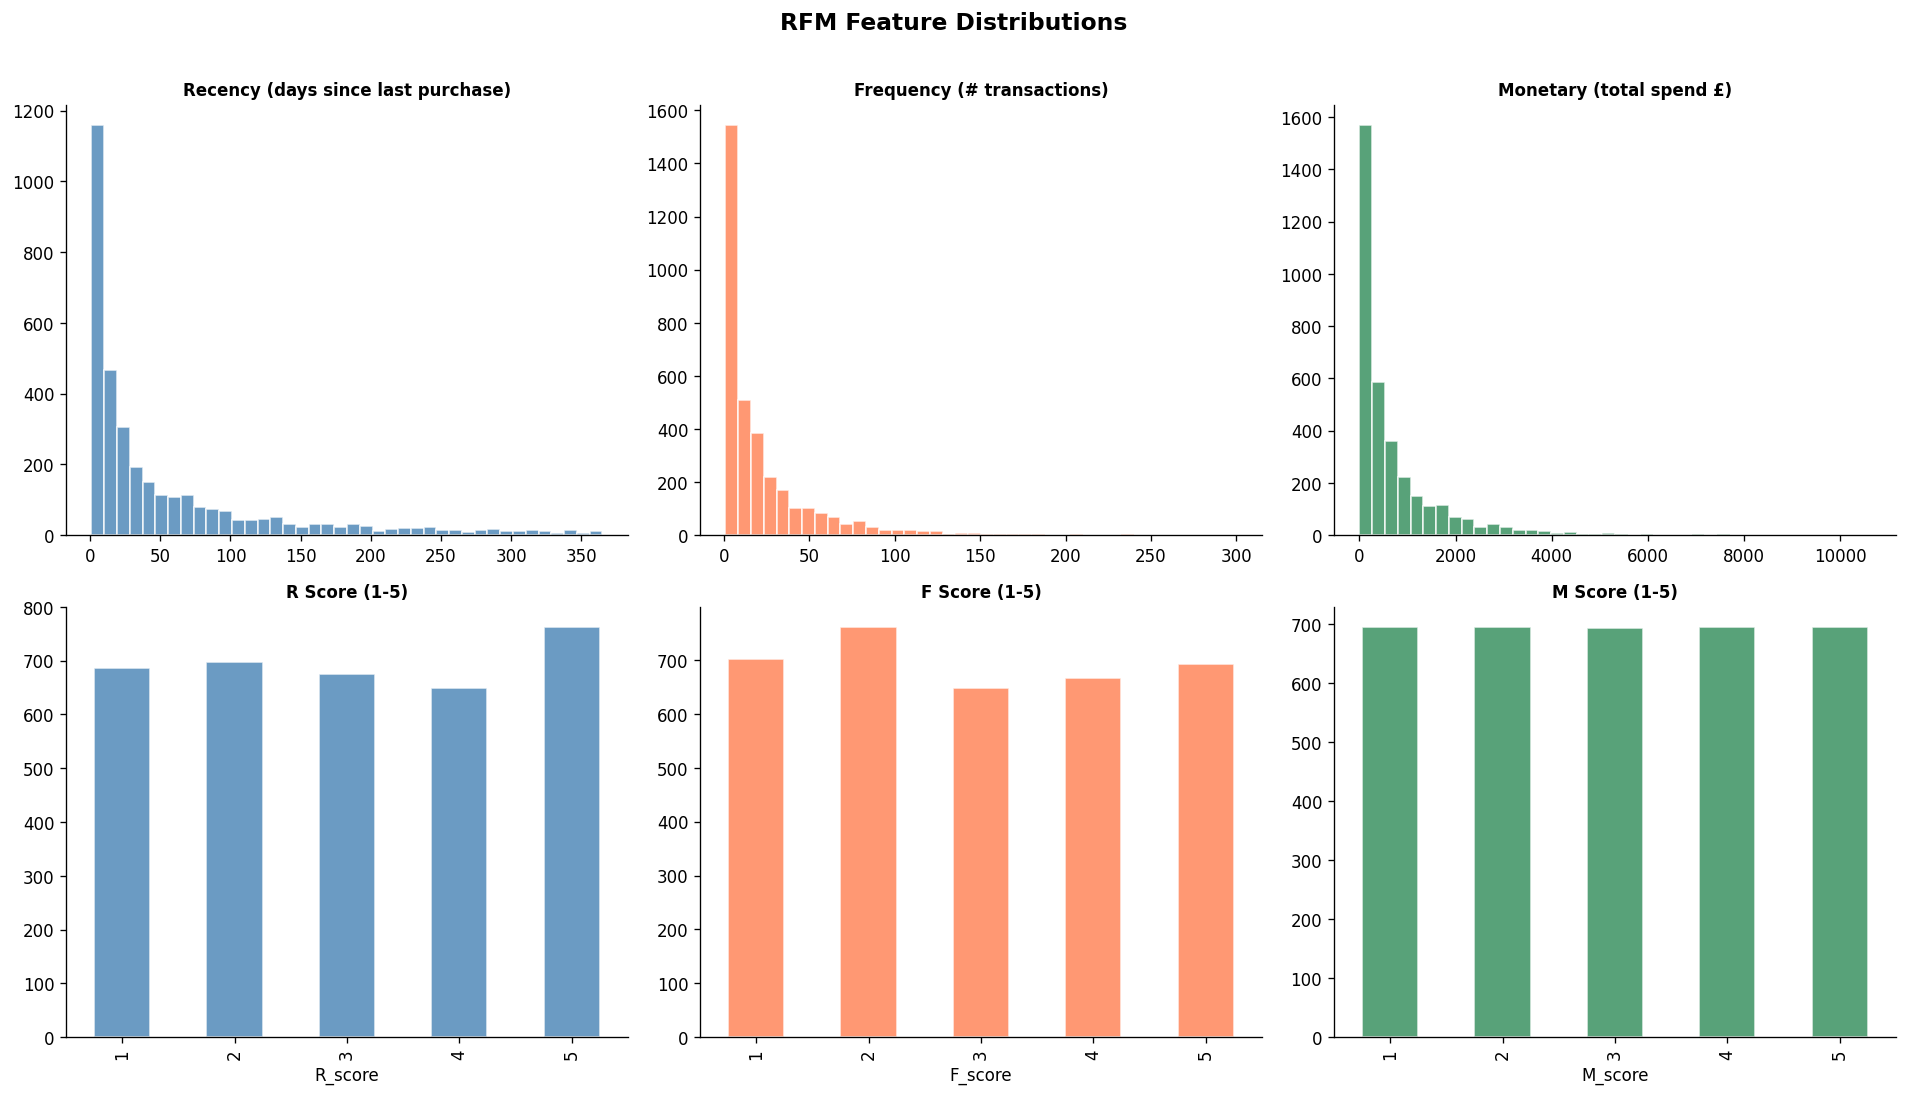

In [2]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

cols = ['recency','frequency','monetary','R_score','F_score','M_score']
titles = ['Recency (days since last purchase)','Frequency (# transactions)',
          'Monetary (total spend £)','R Score (1-5)','F Score (1-5)','M Score (1-5)']
colors = ['steelblue','coral','seagreen','steelblue','coral','seagreen']

for ax, col, title, color in zip(axes.flatten(), cols, titles, colors):
    if 'score' in col.lower() or col in ['R_score','F_score','M_score']:
        rfm[col].value_counts().sort_index().plot(kind='bar', ax=ax, color=color, alpha=0.8, edgecolor='white')
    else:
        ax.hist(rfm[col], bins=40, color=color, alpha=0.8, edgecolor='white')
    ax.set_title(title, fontweight='bold', fontsize=10)

plt.suptitle('RFM Feature Distributions', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('reports/figures/02_rfm_distributions.png', bbox_inches='tight')
plt.show()


## RFM Score Heatmap

How do R and F scores interact? This heatmap shows the density of customers at each R-F combination — the top-right corner (high R score, high F score) represents Champions.

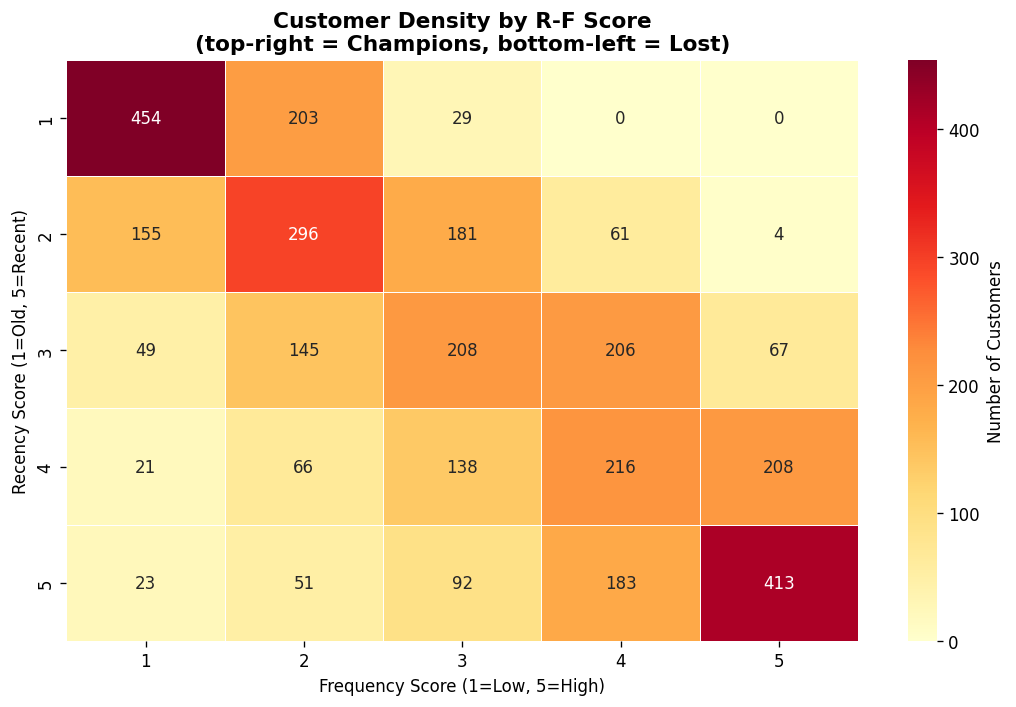

In [3]:
pivot = rfm.groupby(['R_score','F_score'])['customer_id'].count().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'Number of Customers'})
ax.set_title('Customer Density by R-F Score\n(top-right = Champions, bottom-left = Lost)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Frequency Score (1=Low, 5=High)')
ax.set_ylabel('Recency Score (1=Old, 5=Recent)')
plt.tight_layout()
plt.savefig('reports/figures/02_rfm_heatmap.png', bbox_inches='tight')
plt.show()


## Customer Segment Profiling

Using RFM total score to assign business-meaningful labels. These labels are what gets communicated to marketing teams.

In [4]:
def label_customer(row):
    if row['R_score'] >= 4 and row['F_score'] >= 4:
        return 'Champions'
    elif row['R_score'] >= 3 and row['F_score'] >= 3:
        return 'Loyal Customers'
    elif row['R_score'] >= 3:
        return 'Potential Loyalists'
    elif row['R_score'] <= 2 and row['F_score'] >= 3:
        return 'At Risk'
    else:
        return 'Lost / Hibernating'

rfm['segment_label'] = rfm.apply(label_customer, axis=1)

# Summary table
summary = rfm.groupby('segment_label').agg(
    n_customers=('customer_id','count'),
    avg_recency=('recency','mean'),
    avg_frequency=('frequency','mean'),
    avg_monetary=('monetary','mean'),
    pct_of_base=('customer_id','count')
).round(1)
summary['pct_of_base'] = (summary['pct_of_base'] / len(rfm) * 100).round(1)
print(summary.to_string())


                     n_customers  avg_recency  avg_frequency  avg_monetary  pct_of_base
segment_label                                                                          
At Risk                      275         61.0           14.0         439.2          7.9
Champions                   1020          5.4           56.9        1769.2         29.4
Lost / Hibernating          1108        140.2            2.8          87.9         31.9
Loyal Customers              711         17.6           19.0         589.1         20.5
Potential Loyalists          355         16.7            4.2         135.0         10.2


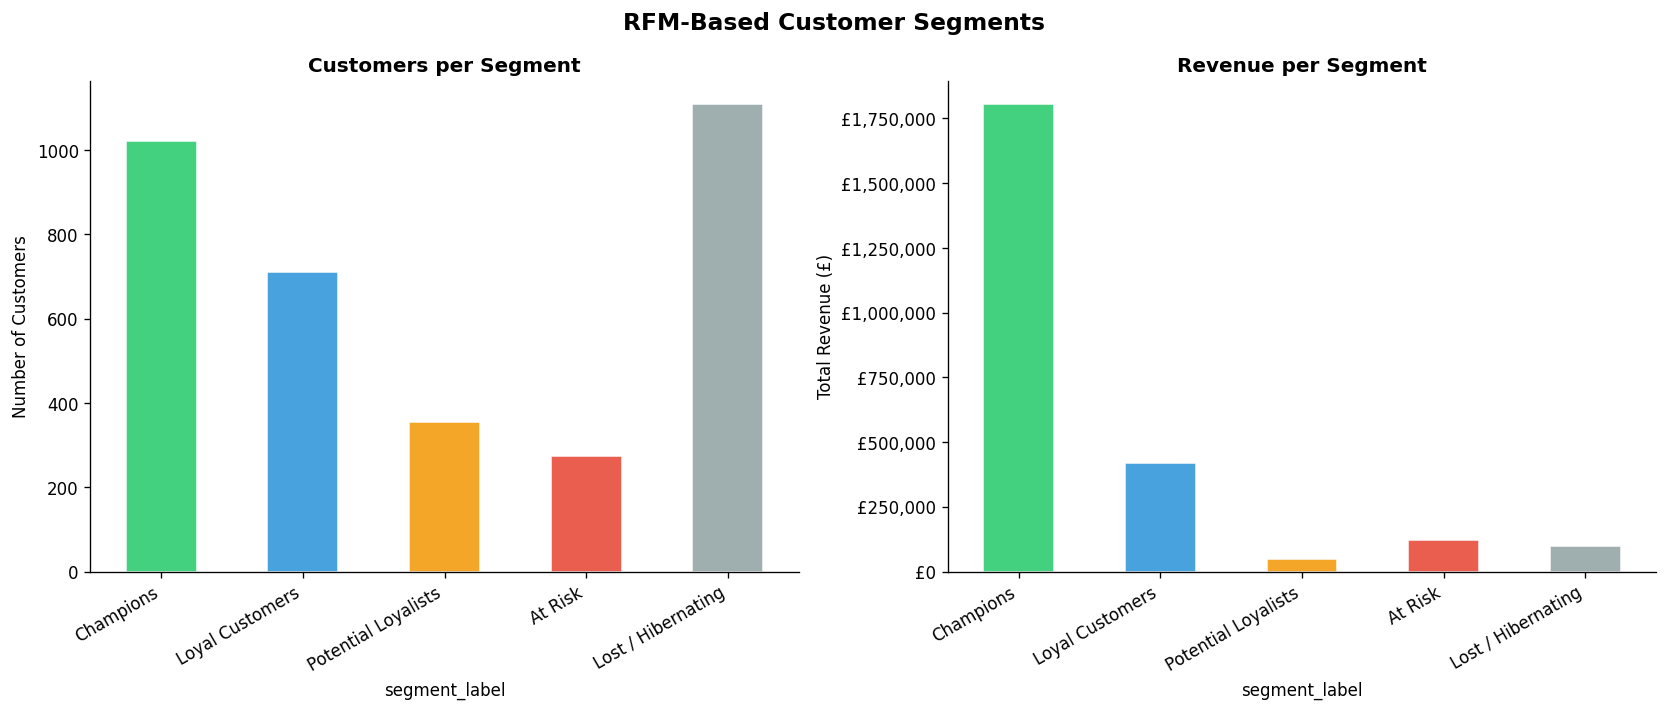

In [5]:
# Segment size and revenue contribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
segment_order = ['Champions','Loyal Customers','Potential Loyalists','At Risk','Lost / Hibernating']
colors_seg = ['#2ecc71','#3498db','#f39c12','#e74c3c','#95a5a6']

seg_counts = rfm['segment_label'].value_counts().reindex(segment_order)
seg_revenue = rfm.groupby('segment_label')['monetary'].sum().reindex(segment_order)

seg_counts.plot(kind='bar', ax=axes[0], color=colors_seg, edgecolor='white', alpha=0.9)
axes[0].set_title('Customers per Segment', fontweight='bold')
axes[0].set_ylabel('Number of Customers')
axes[0].set_xticklabels(segment_order, rotation=30, ha='right')

seg_revenue.plot(kind='bar', ax=axes[1], color=colors_seg, edgecolor='white', alpha=0.9)
axes[1].set_title('Revenue per Segment', fontweight='bold')
axes[1].set_ylabel('Total Revenue (£)')
axes[1].set_xticklabels(segment_order, rotation=30, ha='right')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'£{x:,.0f}'))

plt.suptitle('RFM-Based Customer Segments', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('reports/figures/02_segment_profiles.png', bbox_inches='tight')
plt.show()


## Key Takeaways

| Segment | Strategy |
|---------|----------|
| **Champions** | Reward with loyalty points, early access to new products |
| **Loyal Customers** | Upsell premium lines (No7, Boots Opticians) |
| **Potential Loyalists** | Targeted email campaigns, personalised recommendations |
| **At Risk** | Win-back promotions, 'We miss you' discounts |
| **Lost / Hibernating** | Low-cost re-engagement or deprioritise marketing spend |

**Next:** → `03_ML_Segmentation_KMeans_DBSCAN.ipynb`